In [28]:
import os
import collections
import pandas as pd
import numpy as np
import functools
import matplotlib.pyplot as plt
import cv2

from sklearn import preprocessing


import xml.etree.ElementTree as ET

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data import SequentialSampler

In [29]:
train_dataset =torchvision.datasets.VOCDetection(root='./data',year='2007',download=True,image_set='train')
val_dataset = torchvision.datasets.VOCDetection(root='./data',year='2007',download=True,image_set='val')
test_dataset = torchvision.datasets.VOCDetection(root='./data',year='2007',download=True,image_set='test')

Using downloaded and verified file: ./data/VOCtrainval_06-Nov-2007.tar
Extracting ./data/VOCtrainval_06-Nov-2007.tar to ./data
Using downloaded and verified file: ./data/VOCtrainval_06-Nov-2007.tar
Extracting ./data/VOCtrainval_06-Nov-2007.tar to ./data
Using downloaded and verified file: ./data/VOCtest_06-Nov-2007.tar
Extracting ./data/VOCtest_06-Nov-2007.tar to ./data


In [30]:
BASE_PATH = "./data/VOCdevkit/VOC2007"
XML_PATH = os.path.join(BASE_PATH, "Annotations")
IMG_PATH = os.path.join(BASE_PATH, "JPEGImages")
SEG_PATH = os.path.join(BASE_PATH, "SegmentationObject")
XML_FILES = [os.path.join(XML_PATH, f) for f in os.listdir(XML_PATH)]

In [31]:
class XmlParser(object):

    def __init__(self,xml_file):

        self.xml_file = xml_file
        self._root = ET.parse(self.xml_file).getroot()
        self._objects = self._root.findall("object")
        # path to the image file as describe in the xml file
        self.img_path = os.path.join(IMG_PATH, self._root.find('filename').text)
        # image id
        self.image_id = self._root.find("filename").text
        # names of the classes contained in the xml file
        self.names = self._get_names()
        # coordinates of the bounding boxes
        self.boxes = self._get_bndbox()

    def parse_xml(self):
        """"Parse the xml file returning the root."""

        tree = ET.parse(self.xml_file)
        return tree.getroot()

    def _get_names(self):

        names = []
        for obj in self._objects:
            name = obj.find("name")
            names.append(name.text)

        return np.array(names)

    def _get_bndbox(self):

        boxes = []
        for obj in self._objects:
            coordinates = []
            bndbox = obj.find("bndbox")
            coordinates.append(np.int32(bndbox.find("xmin").text))
            coordinates.append(np.int32(np.float32(bndbox.find("ymin").text)))
            coordinates.append(np.int32(bndbox.find("xmax").text))
            coordinates.append(np.int32(bndbox.find("ymax").text))
            boxes.append(coordinates)

        return np.array(boxes)

In [32]:
def xml_files_to_df(xml_files):

    """"Return pandas dataframe from list of XML files."""

    names = []
    boxes = []
    image_id = []
    xml_path = []
    img_path = []
    for file in xml_files:
        xml = XmlParser(file)
        names.extend(xml.names)
        boxes.extend(xml.boxes)
        image_id.extend([xml.image_id] * len(xml.names))
        xml_path.extend([xml.xml_file] * len(xml.names))
        img_path.extend([xml.img_path] * len(xml.names))
    a = {"image_id": image_id,
         "names": names,
         "boxes": boxes,
         "xml_path":xml_path,
         "img_path":img_path}

    df = pd.DataFrame.from_dict(a, orient='index')
    df = df.transpose()

    return df

df = xml_files_to_df(XML_FILES)
df.head()

,image_id,names,boxes,xml_path,img_path
0,006866.jpg,person,"[221, 44, 331, 218]",./data/VOCdevkit/VOC2007/Annotations/006866.xml,./data/VOCdevkit/VOC2007/JPEGImages/006866.jpg
1,006866.jpg,horse,"[43, 56, 407, 374]",./data/VOCdevkit/VOC2007/Annotations/006866.xml,./data/VOCdevkit/VOC2007/JPEGImages/006866.jpg
2,006866.jpg,person,"[94, 130, 129, 177]",./data/VOCdevkit/VOC2007/Annotations/006866.xml,./data/VOCdevkit/VOC2007/JPEGImages/006866.jpg
3,008403.jpg,cat,"[229, 17, 499, 385]",./data/VOCdevkit/VOC2007/Annotations/008403.xml,./data/VOCdevkit/VOC2007/JPEGImages/008403.jpg
4,002310.jpg,bird,"[154, 30, 484, 333]",./data/VOCdevkit/VOC2007/Annotations/002310.xml,./data/VOCdevkit/VOC2007/JPEGImages/002310.jpg


In [33]:
df['names'].value_counts()

person         10674
car             3185
chair           2806
bottle          1291
pottedplant     1217
bird            1175
dog             1068
sofa             821
bicycle          807
horse            801
boat             791
cat              759
motorbike        759
tvmonitor        728
cow              685
sheep            664
aeroplane        642
train            630
diningtable      609
bus              526
Name: names, dtype: int64

In [34]:
df['img_id'] = df['image_id'].apply(lambda x:x.split('.')).map(lambda x:x[0])
df.drop(columns=['image_id'], inplace=True)
df.head()

,names,boxes,xml_path,img_path,img_id
0,person,"[221, 44, 331, 218]",./data/VOCdevkit/VOC2007/Annotations/006866.xml,./data/VOCdevkit/VOC2007/JPEGImages/006866.jpg,006866
1,horse,"[43, 56, 407, 374]",./data/VOCdevkit/VOC2007/Annotations/006866.xml,./data/VOCdevkit/VOC2007/JPEGImages/006866.jpg,006866
2,person,"[94, 130, 129, 177]",./data/VOCdevkit/VOC2007/Annotations/006866.xml,./data/VOCdevkit/VOC2007/JPEGImages/006866.jpg,006866
3,cat,"[229, 17, 499, 385]",./data/VOCdevkit/VOC2007/Annotations/008403.xml,./data/VOCdevkit/VOC2007/JPEGImages/008403.jpg,008403
4,bird,"[154, 30, 484, 333]",./data/VOCdevkit/VOC2007/Annotations/002310.xml,./data/VOCdevkit/VOC2007/JPEGImages/002310.jpg,002310


In [35]:
enc = preprocessing.LabelEncoder()
df['labels'] = enc.fit_transform(df['names'])
df['labels'] = np.stack(df['labels'][i]+1 for i in range(len(df['labels'])))

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3473: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


In [36]:
classes = df[['names','labels']].value_counts()
classes

names        labels
person       15        10674
car          7          3185
chair        9          2806
bottle       5          1291
pottedplant  16         1217
bird         3          1175
dog          12         1068
sofa         18          821
bicycle      2           807
horse        13          801
boat         4           791
cat          8           759
motorbike    14          759
tvmonitor    20          728
cow          10          685
sheep        17          664
aeroplane    1           642
train        19          630
diningtable  11          609
bus          6           526
dtype: int64

In [37]:
classes= {1:'aeroplane',2:'bicycle',3:'bird',4:'boat',5:'bottle',6:'bus',7:'car',8:'cat',9:'chair',10:'cow',11:'diningtable',12:'dog',13:'horse',14:'motorbike',15:'person',16:'pottedplant',17:'sheep',18:'sofa',19:'train',20:'tvmonitor'}

In [38]:
!pip install albumentations==1.2.1

In [39]:
df['xmin'] = -1
df['ymin'] = -1
df['xmax'] = -1
df['ymax'] = -1

df[['xmin','ymin','xmax','ymax']]=np.stack(df['boxes'][i] for i in range(len(df['boxes'])))

df.drop(columns=['boxes'], inplace=True)
df['xmin'] = df['xmin'].astype(np.float)
df['ymin'] = df['ymin'].astype(np.float)
df['xmax'] = df['xmax'].astype(np.float)
df['ymax'] = df['ymax'].astype(np.float)

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3473: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):
<ipython-input-39-a8b129e4fc15>:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  df['xmin'] = df['xmin'].astype(np.float)
<ipython-input-39-a8b129e4fc15>:10: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavio

In [40]:
df.drop(columns=['names'], inplace=True)
df.head()

,xml_path,img_path,img_id,labels,xmin,ymin,xmax,ymax
0,./data/VOCdevkit/VOC2007/Annotations/006866.xml,./data/VOCdevkit/VOC2007/JPEGImages/006866.jpg,006866,15,221.0,44.0,331.0,218.0
1,./data/VOCdevkit/VOC2007/Annotations/006866.xml,./data/VOCdevkit/VOC2007/JPEGImages/006866.jpg,006866,13,43.0,56.0,407.0,374.0
2,./data/VOCdevkit/VOC2007/Annotations/006866.xml,./data/VOCdevkit/VOC2007/JPEGImages/006866.jpg,006866,15,94.0,130.0,129.0,177.0
3,./data/VOCdevkit/VOC2007/Annotations/008403.xml,./data/VOCdevkit/VOC2007/JPEGImages/008403.jpg,008403,8,229.0,17.0,499.0,385.0
4,./data/VOCdevkit/VOC2007/Annotations/002310.xml,./data/VOCdevkit/VOC2007/JPEGImages/002310.jpg,002310,3,154.0,30.0,484.0,333.0


In [41]:
len(df['img_id'].unique())

9963

In [42]:
image_ids = df['img_id'].unique()
valid_ids = image_ids[-4000:]
train_ids = image_ids[:-4000]
len(train_ids)

5963

In [43]:
valid_df = df[df['img_id'].isin(valid_ids)]
train_df = df[df['img_id'].isin(train_ids)]
valid_df.shape, train_df.shape

((12165, 8), (18473, 8))

In [44]:
class VOCDataset(Dataset):

    def __init__(self, dataframe, image_dir, transforms=None):
        super().__init__()

        self.image_ids = dataframe['img_id'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms

    def __getitem__(self, index: int):
        image_id = self.image_ids[index]
        records = self.df[self.df['img_id'] == image_id]

        image = cv2.imread(f'{self.image_dir}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        rows, cols = image.shape[:2]

        boxes = records[['xmin', 'ymin', 'xmax', 'ymax']].values

        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)

        label = records['labels'].values
        labels = torch.as_tensor(label, dtype=torch.int64)

        # suppose all instances are not crowd
        iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)

        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        # target['masks'] = None
        target['image_id'] = torch.tensor([index])
        target['area'] = area
        target['iscrowd'] = iscrowd

        if self.transforms:
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': labels
            }
            sample = self.transforms(**sample)
            image = sample['image']

            target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1,0)
            return image, target

    def __len__(self) -> int:
        return self.image_ids.shape[0]

In [45]:
def get_transform_train():
    return A.Compose([
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.2),
        ToTensorV2(p=1.0)
    ], bbox_params={'format':'pascal_voc', 'label_fields': ['labels']})

def get_transform_valid():
    return A.Compose([
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields':['labels']})

In [46]:
def collate_fn(batch):
    return tuple(zip(*batch))

train_dataset = VOCDataset(train_df, IMG_PATH , get_transform_train())
valid_dataset = VOCDataset(valid_df, IMG_PATH, get_transform_valid())


# split the dataset in train and test set
indices = torch.randperm(len(train_dataset)).tolist()


train_data_loader = DataLoader(
    train_dataset,
    batch_size=4,
    shuffle=True,
    num_workers=4,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [47]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

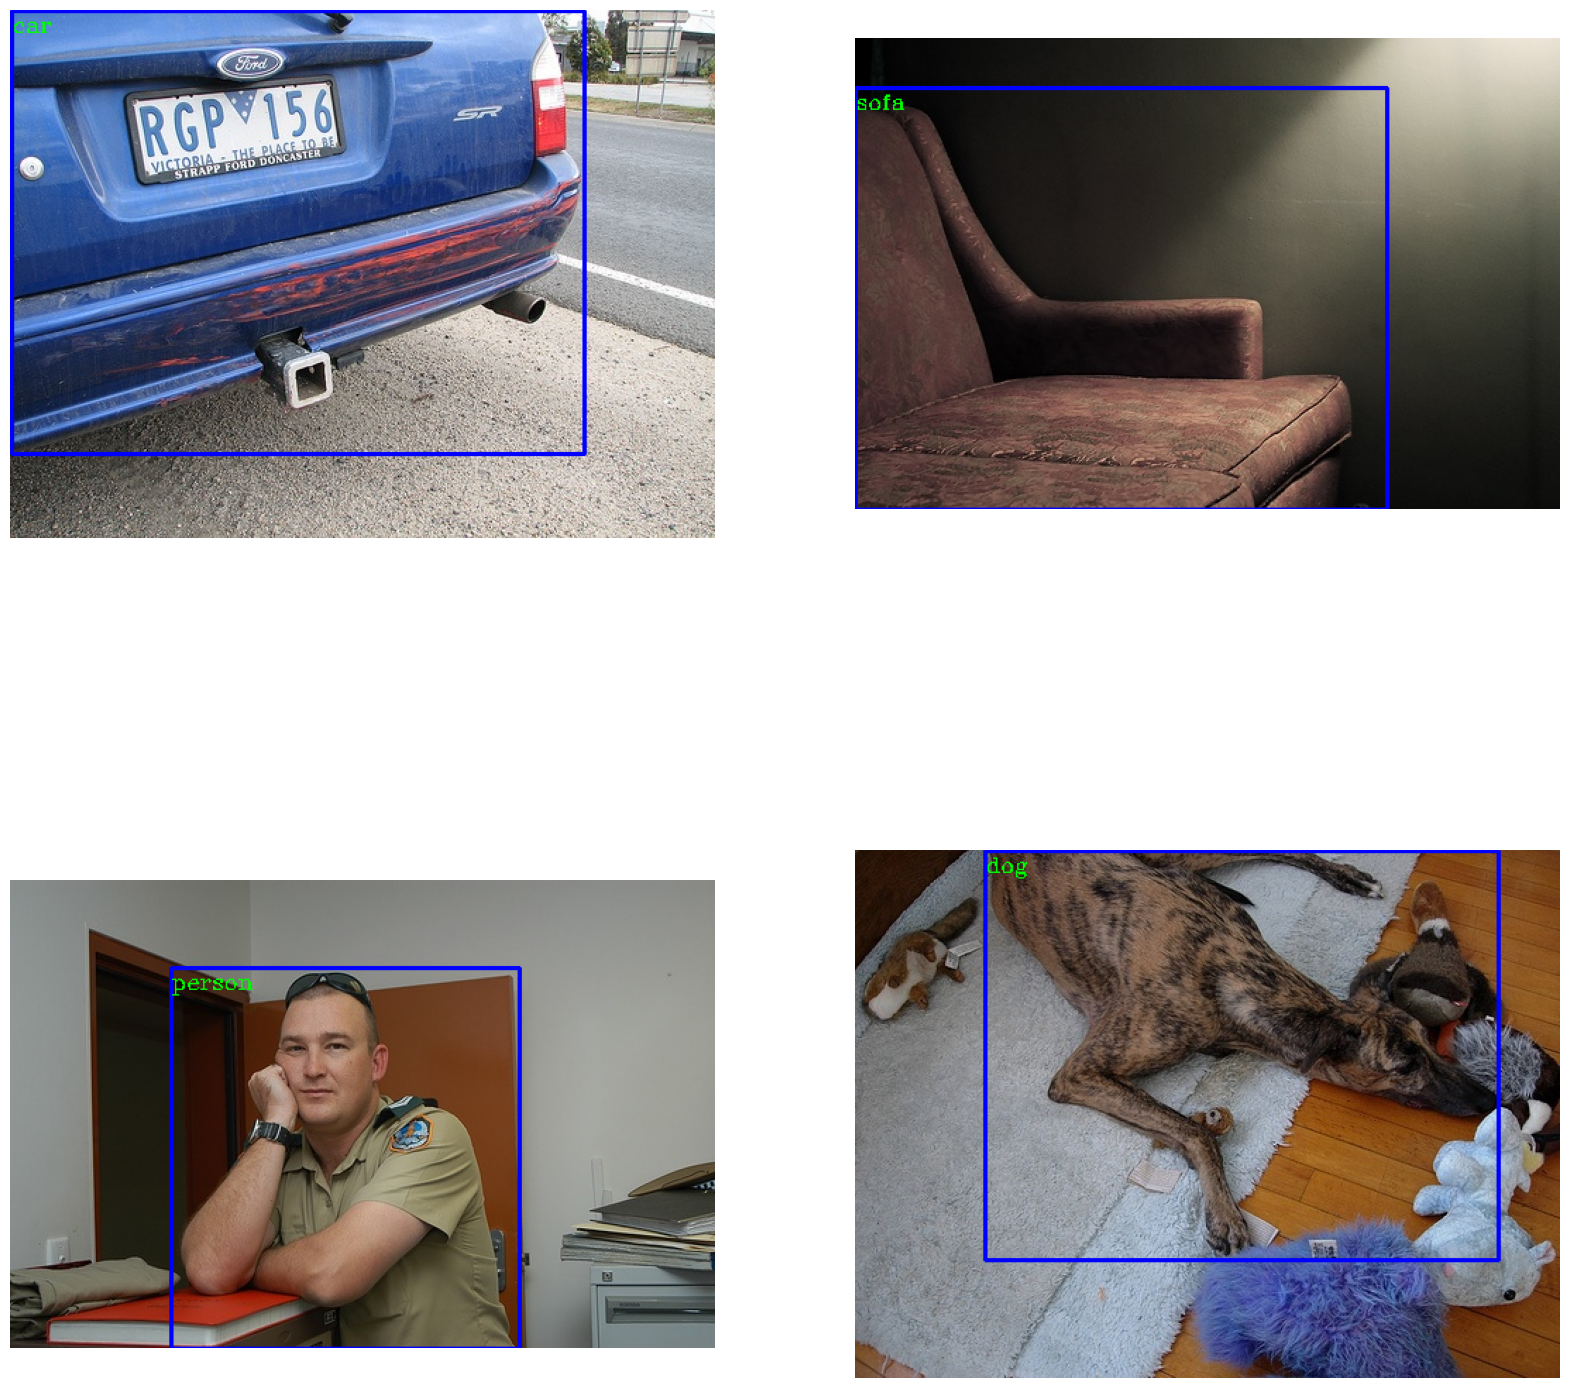

In [48]:
images, targets= next(iter(train_data_loader))
images = list(image.to(device) for image in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

plt.figure(figsize=(20,20))
for i, (image, target) in enumerate(zip(images, targets)):
    plt.subplot(2,2, i+1)
    boxes = targets[i]['boxes'].cpu().numpy().astype(np.int32)
    sample = images[i].permute(1,2,0).cpu().numpy()
    names = targets[i]['labels'].cpu().numpy().astype(np.int64)
    for i,box in enumerate(boxes):
        cv2.rectangle(sample,
                      (box[0], box[1]),
                      (box[2], box[3]),
                      (0, 0, 220), 2)
        cv2.putText(sample, classes[names[i]], (box[0],box[1]+15),cv2.FONT_HERSHEY_COMPLEX ,0.5,(0,220,0),1,cv2.LINE_AA)

    plt.axis('off')
    plt.imshow(sample)

In [49]:
import scipy.optimize

def box_iou(box1, box2):
    """Compute IoU between two bounding boxes.
    Args:
        box1: (tensor) bounding boxes, sized [N,4].
        box2: (tensor) bounding boxes, sized [M,4].
    Return:
        (tensor) IoU, sized [N,M].
    """
    N = box1.size(0)
    M = box2.size(0)

    lt = torch.max(
        box1[:, :2].unsqueeze(1).expand(N, M, 2),
        box2[:, :2].unsqueeze(0).expand(N, M, 2),
    )
    rb = torch.min(
        box1[:, 2:].unsqueeze(1).expand(N, M, 2),
        box2[:, 2:].unsqueeze(0).expand(N, M, 2),
    )

    wh = (rb - lt).clamp(min=0)
    inter = wh[:, :, 0] * wh[:, :, 1]

    area1 = (box1[:, 2] - box1[:, 0]) * (box1[:, 3] - box1[:, 1])
    area2 = (box2[:, 2] - box2[:, 0]) * (box2[:, 3] - box2[:, 1])
    iou = inter / (area1.unsqueeze(1) + area2.unsqueeze(0) - inter)
    return iou

def hungarian_algorithm(cost_matrix):
    cost_matrix = cost_matrix.numpy()
    row_ind, col_ind = scipy.optimize.linear_sum_assignment(cost_matrix)
    return torch.tensor(list(zip(row_ind, col_ind)))

def loss_compute(objs, nobox, cls, target, crit1, crit2, crit3):
    box1 = target['boxes']
    cls1 = target['labels']
    box2 = objs
    cls2 = cls

    cost = box_iou(box1.clone().detach().cpu(), box2.clone().detach().cpu())
    idx = hungarian_algorithm(cost)
    pred_box2 = box2[idx[:, 1]][idx[:, 0]]
    pred_cls2 = cls2[idx[:, 1]][idx[:, 0]]
    pred_nbj2 = torch.zeros((256,)).cuda()
    true_nbj2 = torch.zeros((256,)).cuda()
    true_nbj2[idx[:, 0]] = 1
    pred_nbj2 = nobox
    loss1 = crit1(pred_box2.float(), box1.float())/2560
    loss2 = crit2(pred_cls2, cls1)
    loss3 = crit3(pred_nbj2, true_nbj2)
    return {'loss_reg': loss1, 'loss_class': loss2, 'loss_noobj': loss3}
    #return loss1+loss2+loss3

In [50]:
import torch
import torchvision
from torch import nn
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.backbone_utils import BackboneWithFPN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision import transforms


class Permute(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return x.view(-1, 768, 16, 16)

class Interpolate(nn.Module):
    def __init__(self, size=512):
        super().__init__()
        self.size = size

    def forward(self, x):
        h, w = x.shape[-2:]
        x = nn.ZeroPad2d(padding=(0, self.size-w, 0, self.size-h))(x)
        return x

class ViTFeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = torchvision.models.vit_b_32(image_size=512)

    def forward(self, x):
        x = self.model._process_input(x)
        n = x.shape[0]
        # Expand the class token to the full batch
        batch_class_token = self.model.class_token.expand(n, -1, -1)
        x = torch.cat([batch_class_token, x], dim=1)
        x = self.model.encoder(x)
        x = x[:, 1:]

        return x


class ViTBackbone(nn.Module):
    def __init__(self, vit_model, out_channels=768):
        super().__init__()
        self.out_channels = out_channels
        self.layer0 = nn.Sequential(Interpolate(),
                                    vit_model)
        self.bbox_reg = nn.Linear(768, 4)
        self.nobox_reg = nn.Linear(768, 1)
        self.class_reg = nn.Linear(768, 21)
        self.crit1 = torch.nn.MSELoss()
        self.crit2 = torch.nn.CrossEntropyLoss()
        self.crit3 = torch.nn.BCELoss()

    def forward(self, x, target=None):
        if target is not None:
            loss_dicts = {'loss_reg': 0, 'loss_class': 0, 'loss_noobj': 0}
            for i in range(len(x)):
                y = self.layer0(torch.unsqueeze(x[i], 0))
                bbox = self.bbox_reg(y)
                nobox = nn.Softmax(dim=2)(self.nobox_reg(y))
                cls = nn.Softmax(dim=2)(self.class_reg(y))
                h, w = x[i].shape[1:]
                target[i]['boxes'][:, 0] = target[i]['boxes'][:, 0]
                target[i]['boxes'][:, 1] = target[i]['boxes'][:, 1]
                target[i]['boxes'][:, 2] = target[i]['boxes'][:, 2]
                target[i]['boxes'][:, 3] = target[i]['boxes'][:, 3]
                loss_dict = loss_compute(bbox[0], nobox[0, :, 0], cls[0], target[i], self.crit1, self.crit2, self.crit3)
                loss_dicts['loss_reg'] += loss_dict['loss_reg']
                loss_dicts['loss_class'] += loss_dict['loss_class']
                loss_dicts['loss_noobj'] += loss_dict['loss_noobj']
            return loss_dicts
        else:
            preds = []
            for i in range(len(x)):
                y = self.layer0(torch.unsqueeze(x[i], 0))
                bbox = self.bbox_reg(y)
                nobox = nn.Softmax(dim=2)(self.nobox_reg(y))
                cls = nn.Softmax(dim=2)(self.class_reg(y))
                h, w = x[i].shape[1:]
                target = {}
                target['boxes'] = []
                target['boxes'].append(bbox[0, :, 0])
                target['boxes'].append(bbox[0, :, 1])
                target['boxes'].append(bbox[0, :, 2])
                target['boxes'].append(bbox[0, :, 3])
                target['boxes'] = torch.vstack(target['boxes']).T
                target['labels'] = torch.argmax(cls[0], 1)
                target['scores'] = nobox.squeeze()
                preds.append(target)
            return preds

num_classes=21

vit_model = ViTFeatureExtractor()
vit_backbone = ViTBackbone(vit_model)

img = torch.randn((1, 3, 333, 333))
out = vit_backbone(img)

In [51]:
vit_backbone.cuda()
params = [p for p in vit_backbone.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [52]:
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
!git clone https://github.com/pytorch/vision.git
!cd vision;cp references/detection/utils.py ../;cp references/detection/transforms.py ../;cp references/detection/coco_eval.py ../;cp references/detection/engine.py ../;cp references/detection/coco_utils.py ../

  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-x5ciu0ns
  Running command git clone --filter=blob:none --quiet https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-x5ciu0ns
  Resolved https://github.com/cocodataset/cocoapi.git to commit 8c9bcc3cf640524c4c20a9c40e89cb6a2f2fa0e9
  Preparing metadata (setup.py) ... done
fatal: destination path 'vision' already exists and is not an empty directory.


In [53]:
from engine import train_one_epoch, evaluate
import utils

In [54]:
num_epochs = 21
vit_backbone.cuda()

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(vit_backbone, optimizer, train_data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(vit_backbone, valid_data_loader, device=device)

Epoch: [0]  [   0/1491]  eta: 0:33:53  lr: 0.000010  loss: 555.4719 (555.4719)  loss_reg: 145.3668 (145.3668)  loss_class: 12.0583 (12.0583)  loss_noobj: 398.0469 (398.0469)  time: 1.3637  data: 0.9000  max mem: 2323
Epoch: [0]  [  10/1491]  eta: 0:10:35  lr: 0.000060  loss: 520.9690 (519.3981)  loss_reg: 114.7640 (113.8202)  loss_class: 12.1009 (12.1120)  loss_noobj: 394.5312 (393.4659)  time: 0.4288  data: 0.1033  max mem: 2465
Epoch: [0]  [  20/1491]  eta: 0:10:10  lr: 0.000110  loss: 514.4832 (518.3920)  loss_reg: 108.3212 (111.9811)  loss_class: 12.0750 (12.0656)  loss_noobj: 394.9219 (394.3452)  time: 0.3675  data: 0.0268  max mem: 2466
Epoch: [0]  [  30/1491]  eta: 0:10:32  lr: 0.000160  loss: 514.4832 (517.9050)  loss_reg: 107.9499 (110.9657)  loss_class: 12.0268 (12.0301)  loss_noobj: 396.0938 (394.9093)  time: 0.4347  data: 0.0329  max mem: 2466
Epoch: [0]  [  40/1491]  eta: 0:10:06  lr: 0.000210  loss: 515.5377 (517.3158)  loss_reg: 107.9499 (110.0797)  loss_class: 12.0005 (

KeyboardInterrupt: ignored